In [81]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

# To avoid warnings
import warnings
warnings.filterwarnings("ignore")

In [82]:
# Load Dataset
df = pd.read_csv("AAPL.csv")

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [83]:
# Handle Missing Values
# Check missing values
print(df.isnull().sum())
# Fill missing values using forward fill
df = df.fillna(method='ffill')
# If still missing, backfill
df = df.fillna(method='bfill')


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [84]:
df.duplicated().sum()

np.int64(0)

In [85]:
# STEP 4: Feature Engineering

# Moving Averages
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Volatility (Rolling Std Dev)
df['Volatility_10'] = df['Close'].rolling(window=10).std()
df['Volatility_20'] = df['Close'].rolling(window=20).std()

# Daily Returns
df['Daily_Return'] = df['Close'].pct_change()

# Target Variable: Next 30-Day Close Price
df['Target_Close_30'] = df['Close'].shift(-30)

df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA_10,MA_20,MA_50,Volatility_10,Volatility_20,Daily_Return,Target_Close_30
2006,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000,276.932996,271.181998,259.6744,5.130104,7.221150,0.016318,NaN
2007,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700,278.511993,272.076997,260.6424,4.646479,7.687566,0.000951,NaN
2008,2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300,280.425995,273.357997,261.7342,5.029357,8.421259,0.019840,NaN
2009,2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500,282.259995,274.455997,262.8428,4.731653,9.070523,-0.000379,NaN
2010,2019-12-30,289.459991,292.690002,285.220001,291.519989,289.522614,36028600,283.896994,275.669496,263.9676,4.829246,9.660051,0.005935,NaN


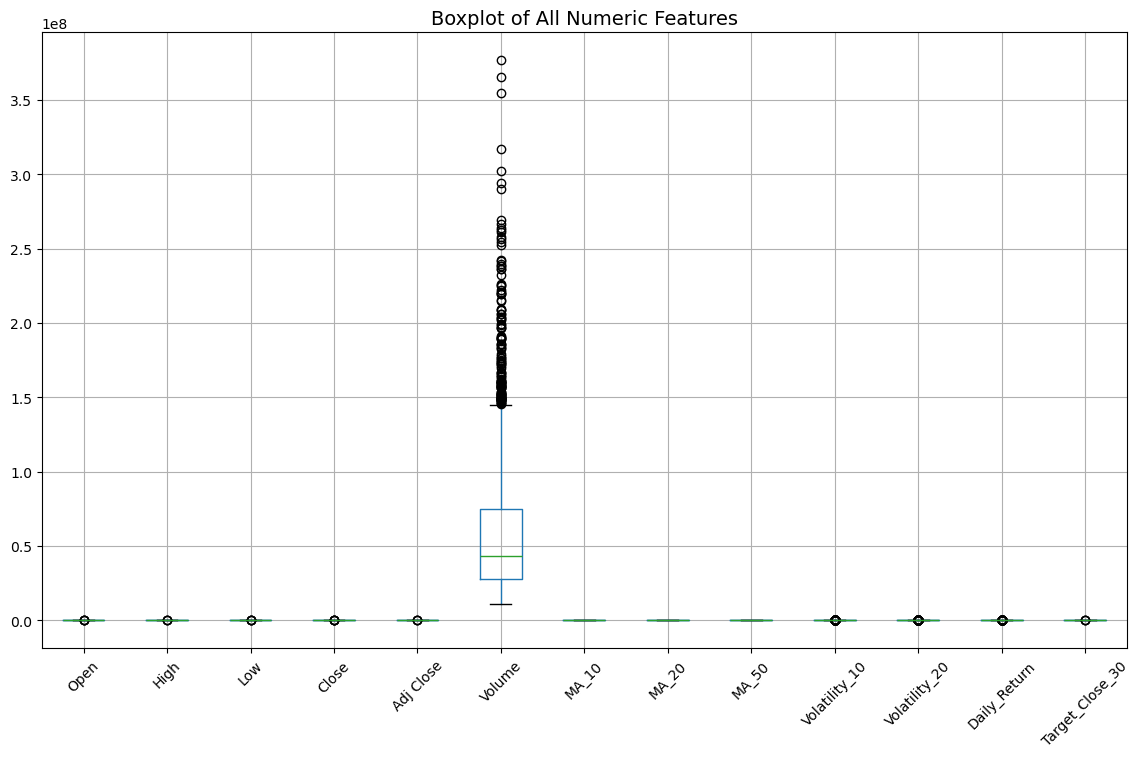

In [86]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

plt.figure(figsize=(14, 8))
df[numeric_cols].boxplot()
plt.title("Boxplot of All Numeric Features", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [87]:
def outlier_capping(df,column):
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    lower_extreme=Q1-1.5*IQR
    upper_extreme=Q3+1.5*IQR
    df[column]=df[column].apply(lambda x:lower_extreme if x<lower_extreme else upper_extreme if x>upper_extreme else x)
for col in df.select_dtypes(['int','float']).columns:
    outlier_capping(df,col)

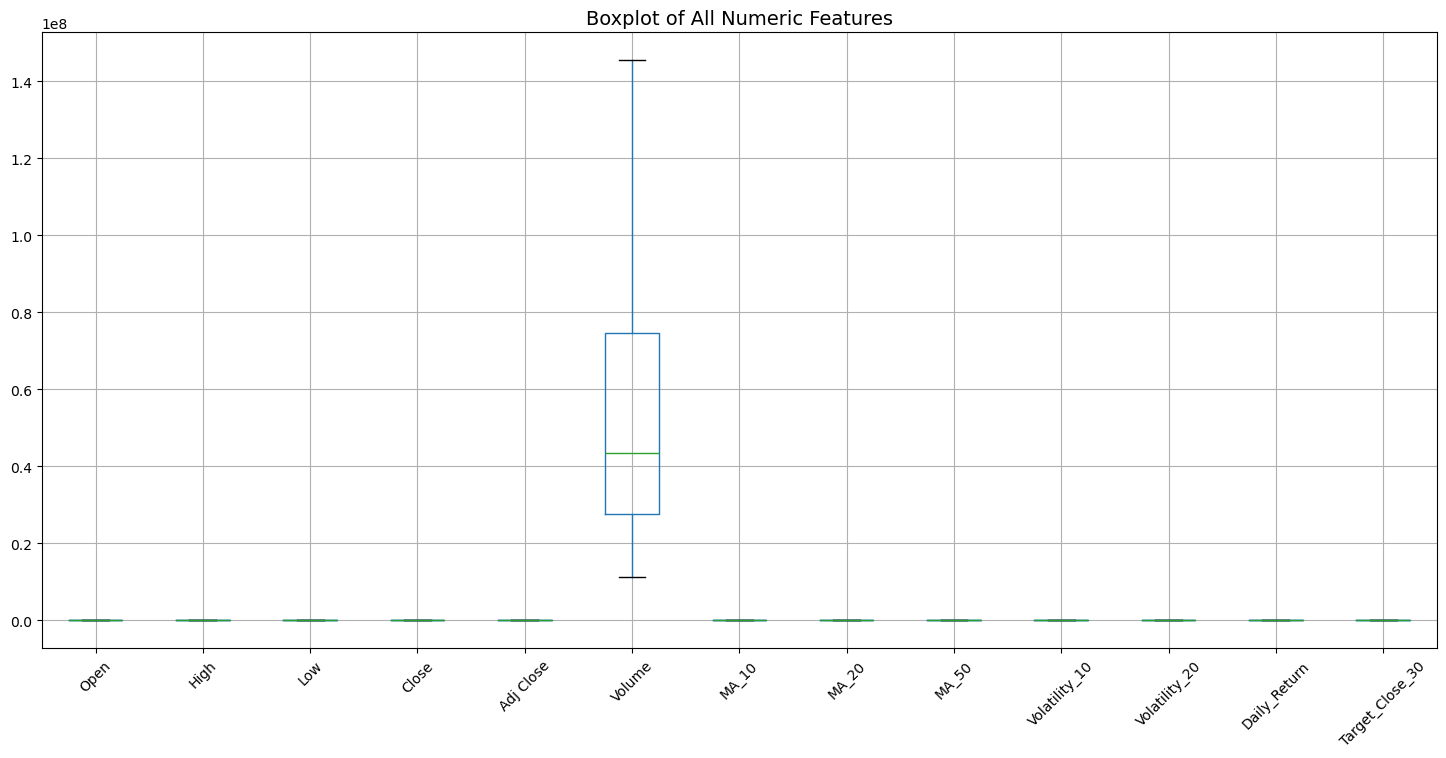

In [88]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

plt.figure(figsize=(18, 8))
df[numeric_cols].boxplot()
plt.title("Boxplot of All Numeric Features", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [89]:
# Drop Rows With NaN Target
df = df.dropna()

df.shape


(1932, 14)

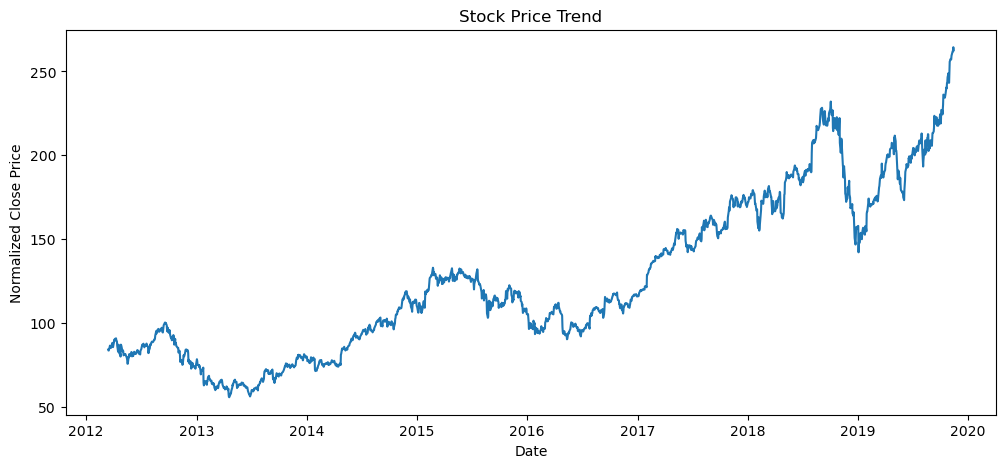

In [90]:
#EDA
# Plot Close Price Trend
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'])
plt.title("Stock Price Trend")
plt.xlabel("Date")
plt.ylabel("Normalized Close Price")
plt.show()


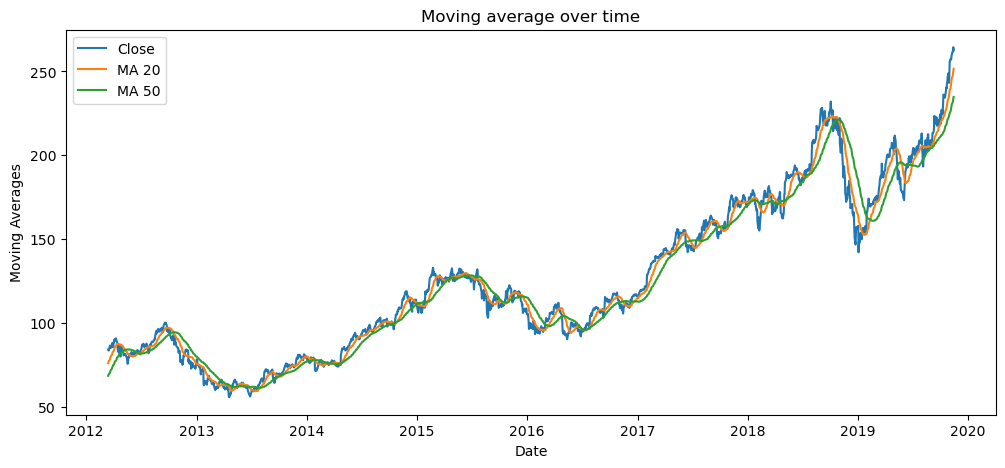

In [91]:
# Moving Averages Comparison
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA_20'], label='MA 20')
plt.plot(df['Date'], df['MA_50'], label='MA 50')
plt.title('Moving average over time')
plt.ylabel("Moving Averages")
plt.xlabel("Date")
plt.legend()
plt.show()


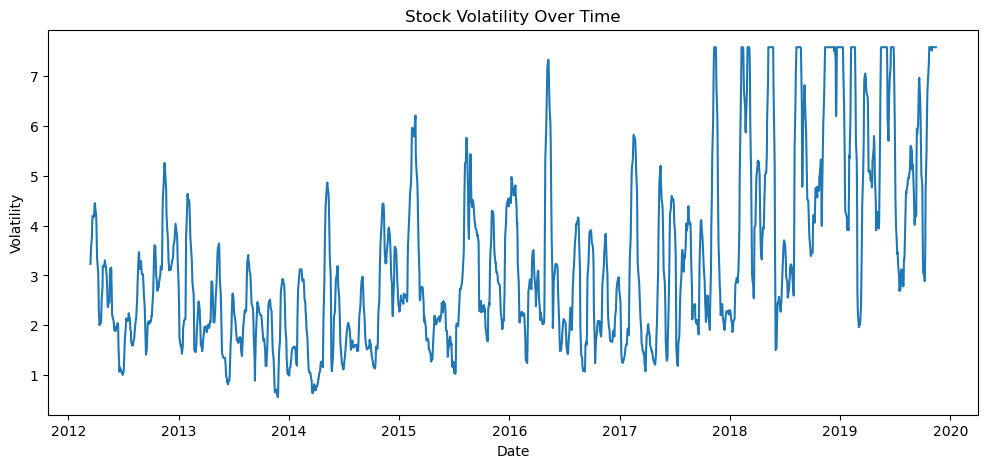

In [92]:
# Volatility visualization
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Volatility_20'], label='20-Day Volatility')
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Stock Volatility Over Time")
plt.show()


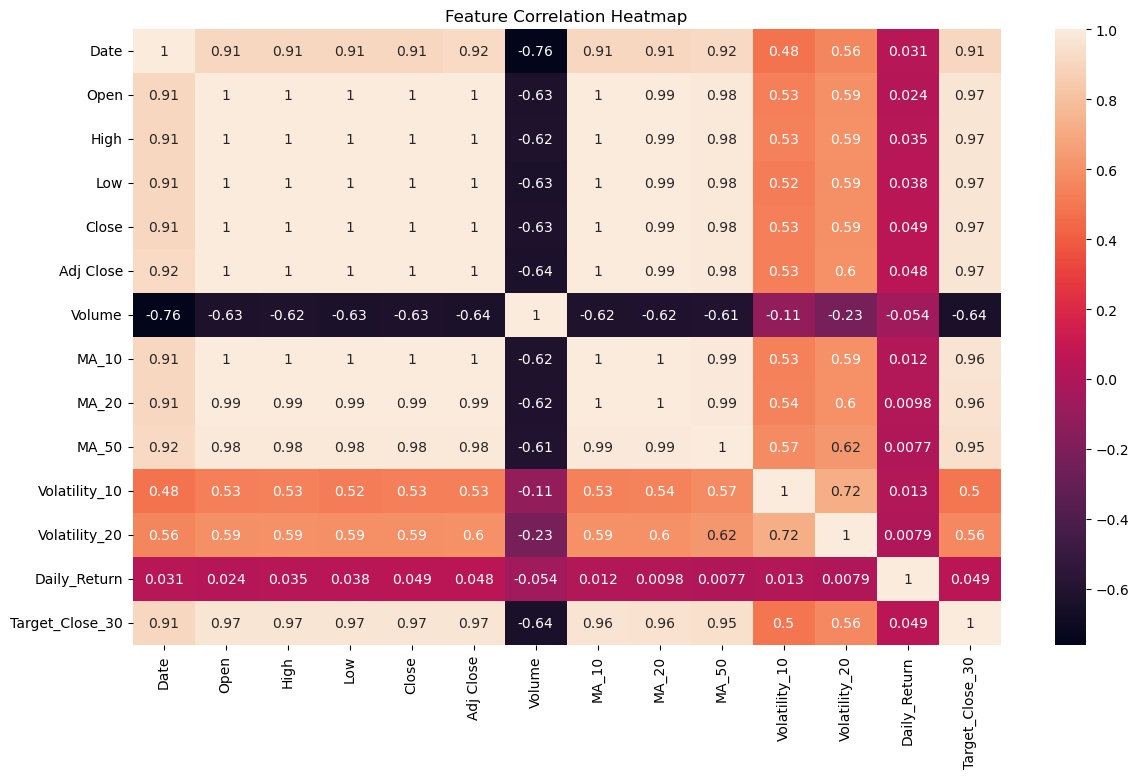

In [93]:
# Correlation Heatmap
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()


### SARIMA

In [94]:
df = df.set_index('Date')

df = df.asfreq('B') 
df = df.ffill()

In [95]:
!pip install yfinance


In [96]:
import yfinance as yf

spx = yf.download("^GSPC",
                  start=df.index.min().strftime("%Y-%m-%d"),
                  end=df.index.max().strftime("%Y-%m-%d"))


[*********************100%***********************]  1 of 1 completed


In [97]:
spx.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2012-03-14,1394.280029,1399.420044,1389.969971,1395.949951,4502280000
2012-03-15,1402.599976,1402.630005,1392.780029,1394.170044,4271650000
2012-03-16,1404.170044,1405.880005,1401.469971,1402.550049,5163950000
2012-03-19,1409.750000,1414.000000,1402.430054,1404.170044,3932570000
2012-03-20,1405.520020,1409.589966,1397.680054,1409.589966,3695280000


In [98]:

spx.columns = spx.columns.get_level_values(0)
spx['SPX_Close'] = spx['Close']
spx = spx[['SPX_Close']]
df = df.join(spx, how='left')
df = df.ffill()



In [99]:
for lag in [1,2,3,5,7]:
    df[f'Close_lag{lag}'] = df['Close'].shift(lag)
df['SPX_Return'] = df['SPX_Close'].pct_change()
df['SPX_Trend_5'] = df['SPX_Close'].rolling(5).mean()
df['SPX_Close_lag1'] = df['SPX_Close'].shift(1)
df['SPX_Return_lag1'] = df['SPX_Return'].shift(1)
df['SPX_Trend_5_lag1'] = df['SPX_Trend_5'].shift(1)

df['Rolling_Mean_20_lag1'] = df['Close'].rolling(20).mean().shift(1)
df['Rolling_Std_20_lag1'] = df['Close'].rolling(20).std().shift(1)


In [100]:
# STEP 4: Feature Engineering

# Moving Averages
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Volatility (Rolling Std Dev)
df['Volatility_10'] = df['Close'].rolling(window=10).std()
df['Volatility_20'] = df['Close'].rolling(window=20).std()

# Daily Returns
df['Daily_Return'] = df['Close'].pct_change()
df['Daily_Return_lag1']=df['Daily_Return'].shift(1)
# Target Variable: Next 30-Day Close Price
df['Target_Close_30'] = df['Close'].shift(-30)

df['Log_Volume'] = np.log1p(df['Volume'])
df['Volatility_20'] = np.log1p(df['Volatility_20'])

df.tail()
cols = ['SPX_Close_lag1','Daily_Return_lag1','SPX_Return_lag1','SPX_Trend_5_lag1','Rolling_Mean_20_lag1','Rolling_Std_20_lag1','SPX_Close','SPX_Return','SPX_Trend_5','Close_lag1','Close_lag2','Close_lag3','Close_lag5','Close_lag7','Close','Open','High','Low','Volume','MA_10','MA_20',
        'Daily_Return','Volatility_10','Volatility_20','Log_Volume']
df = df[cols].dropna()

In [101]:
df.head()

,SPX_Close_lag1,Daily_Return_lag1,SPX_Return_lag1,SPX_Trend_5_lag1,Rolling_Mean_20_lag1,Rolling_Std_20_lag1,SPX_Close,SPX_Return,SPX_Trend_5,Close_lag1,...,Open,High,Low,Volume,MA_10,MA_20,Daily_Return,Volatility_10,Volatility_20,Log_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-11,1358.589966,-0.012244,-0.017081,1387.181958,87.274571,2.329619,1368.709961,0.007449,1381.131958,89.777145,...,90.885712,90.981430,89.048569,145397275.0,89.141428,87.536143,-0.003564,1.660878,1.182337,18.79498
2012-04-12,1368.709961,-0.003564,0.007449,1381.131958,87.536143,2.261987,1387.569946,0.013779,1379.029956,89.457146,...,89.285713,90.190002,88.642860,145397275.0,89.325857,87.801928,-0.005478,1.507104,1.127213,18.79498
2012-04-13,1387.569946,-0.005478,0.013779,1379.029956,87.801928,2.087041,1370.260010,-0.012475,1373.465967,88.967140,...,89.158569,89.242859,86.215714,145397275.0,89.406999,87.942357,-0.028164,1.293981,1.056784,18.79498
2012-04-16,1370.260010,-0.028164,-0.012475,1373.465967,87.942357,1.877102,1369.569946,-0.000504,1370.939966,86.461426,...,87.151428,87.182854,82.607140,145397275.0,88.856999,87.792571,-0.041472,2.441279,1.147607,18.79498
2012-04-17,1369.569946,-0.041472,-0.000504,1370.939966,87.792571,2.150644,1390.780029,0.015487,1377.377979,82.875717,...,82.705711,87.142860,81.701431,145397275.0,88.576713,87.819286,0.050971,2.468608,1.143548,18.79498


In [102]:
series = df.copy()
test_size = int(len(series) * 0.20)
train_raw = series[:-test_size].copy()
test_raw  = series[-test_size:].copy()

print(train_raw.shape, test_raw.shape)

(1586, 25) (396, 25)


In [103]:
y_train = train_raw['Close']
y_test  = test_raw['Close']

In [104]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

exog_cols = ['SPX_Close_lag1', 'Daily_Return_lag1', 'SPX_Return_lag1',
       'SPX_Trend_5_lag1', 'Rolling_Mean_20_lag1', 'Rolling_Std_20_lag1',
       'SPX_Close', 'SPX_Return', 'SPX_Trend_5', 'Close_lag1', 'Close_lag2',
       'Close_lag3', 'Close_lag5', 'Close_lag7', 'Open', 'High',
       'Low', 'MA_10', 'MA_20', 'Volatility_10',
       'Volatility_20', 'Log_Volume']


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(train_raw[exog_cols])
X_test_scaled  = scaler.transform(test_raw[exog_cols])

X_train = pd.DataFrame(X_train_scaled, index=train_raw.index, columns=exog_cols)
X_test  = pd.DataFrame(X_test_scaled, index=test_raw.index, columns=exog_cols)


In [105]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

In [106]:
import pmdarima as pm

auto_model = pm.auto_arima(
    y_train,
    exogenous=X_train[['Low', 'High', 'Open', 'SPX_Return', 'Close_lag1', 'SPX_Trend_5_lag1']],
    seasonal=True,
    m=7,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=1, D=1,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
order = auto_model.order
seasonal_order = auto_model.seasonal_order
print(f"Best model:  ARIMA{order}({seasonal_order})[7]")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=7091.751, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=6578.406, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.74 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=7086.020, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=6463.168, Time=0.60 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=3.87 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.83 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=6463.385, Time=0.52 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=6465.110, Time=0.94 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=6465.136, Time=0.83 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=6463.145, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=6578.499, Time=0.49 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=4.75 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=2.43 sec
 ARIMA(0,1,2)(2,1,0)[7]             : AIC=6465.124, Time=0

In [107]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

selected = []
remaining = exog_cols.copy()
current_aic = float('inf')

while len(remaining) > 0:
    best_aic_this_round = float('inf')
    best_feature = None

    for col in remaining:
        trial = selected + [col]
        try:
            model = SARIMAX(y_train,
                            exog=X_train[trial],
                            order=(1,1,1),
                            seasonal_order=(1,1,1,7))
            res = model.fit(disp=False)

            if res.aic < best_aic_this_round:
                best_aic_this_round = res.aic
                best_feature = col
        except:
            pass

    if best_feature is None:
        break  # nothing left

    if best_aic_this_round < current_aic:
        selected.append(best_feature)
        remaining.remove(best_feature)
        current_aic = best_aic_this_round
        print("Added:", best_feature, "| AIC:", current_aic)
    else:
        break

print("\nFinal selected features:", selected)



Added: Low | AIC: 4138.245223123095
Added: High | AIC: 3526.7743405498472
Added: Open | AIC: 2760.2692129391244
Added: SPX_Return | AIC: 2350.2212835160244
Added: Close_lag1 | AIC: 2347.446852921618
Added: SPX_Close_lag1 | AIC: 2343.2996098242065
Added: SPX_Close | AIC: 2283.2320112667785

Final selected features: ['Low', 'High', 'Open', 'SPX_Return', 'Close_lag1', 'SPX_Close_lag1', 'SPX_Close']


In [108]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y_train,
    exog=X_train[['Low', 'High', 'Open', 'SPX_Return', 'Close_lag1', 'SPX_Close_lag1', 'SPX_Close']],
    order=order,
    seasonal_order=seasonal_order
)

res = model.fit(disp=False)
print(res.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1586
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 7)   Log Likelihood               -1310.661
Date:                            Sun, 30 Nov 2025   AIC                           2643.322
Time:                                    22:27:44   BIC                           2702.325
Sample:                                04-11-2012   HQIC                          2665.247
                                     - 05-09-2018                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Low               21.6359      0.318     68.037      0.000      21.013      22.259
High              26.29

In [109]:
pred = res.get_prediction(
    start=y_test.index[0],
    end=y_test.index[-1],
    exog=X_test[['Low', 'High', 'Open', 'SPX_Return', 'Close_lag1', 'SPX_Close_lag1', 'SPX_Close']]
)

y_pred = pred.predicted_mean


In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)
print("R²  :", r2)


RMSE: 1.2553555258348188
MAE: 0.9637572213154093
MAPE: 0.4925967942261143
R²  : 0.9971892883063875


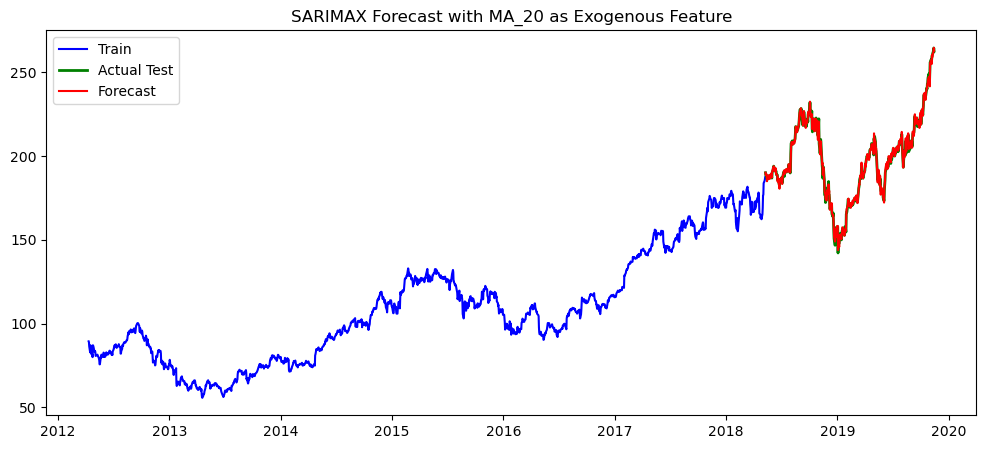

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(y_train, label='Train', color='blue')
plt.plot(y_test, label='Actual Test', color='green', linewidth=2)
plt.plot(y_pred, label='Forecast', color='red')

plt.legend()
plt.title("SARIMAX Forecast with MA_20 as Exogenous Feature")
plt.show()


In [112]:
print(pd.DataFrame({'Actual': y_test[:5], 'Forecast': y_pred[:5]}))


                Actual    Forecast
2018-05-10  190.039993  190.113137
2018-05-11  188.589996  188.806321
2018-05-14  188.149994  189.073673
2018-05-15  186.440002  184.982587
2018-05-16  188.179993  186.863367


### XGBOOST


In [113]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

In [114]:
# STEP 4: Feature Engineering

# Moving Averages
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Volatility (Rolling Std Dev)
df['Volatility_10'] = df['Close'].rolling(window=10).std()
df['Volatility_20'] = df['Close'].rolling(window=20).std()

# Daily Returns
df['Daily_Return'] = df['Close'].pct_change()

# Target Variable: Next 30-Day Close Price
df['Target_Close_30'] = df['Close'].shift(-30)

df.tail()

,SPX_Close_lag1,Daily_Return_lag1,SPX_Return_lag1,SPX_Trend_5_lag1,Rolling_Mean_20_lag1,Rolling_Std_20_lag1,SPX_Close,SPX_Return,SPX_Trend_5,Close_lag1,...,Low,Volume,MA_10,MA_20,Daily_Return,Volatility_10,Volatility_20,Log_Volume,MA_50,Target_Close_30
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-08,3085.179932,0.008513,0.002730,3076.352002,244.937499,8.595865,3093.080078,0.002561,3081.586035,259.429993,...,256.850006,17496600.0,253.162000,246.134000,0.002737,6.481008,8.974244,16.677517,230.5498,NaN
2019-11-11,3093.080078,0.002737,0.002561,3081.586035,246.134000,8.974244,3087.010010,-0.001962,3083.334033,260.140015,...,258.279999,20455300.0,254.477001,247.450501,0.007919,6.876013,9.314130,16.833753,231.6190,NaN
2019-11-12,3087.010010,0.007919,-0.001962,3083.334033,247.450501,9.314130,3091.840088,0.001565,3086.778027,262.200012,...,260.920013,21847200.0,256.344000,248.782500,-0.000915,5.976855,9.392605,16.899583,232.7442,NaN
2019-11-13,3091.840088,-0.000915,0.001565,3086.778027,248.782500,9.392605,3094.040039,0.000712,3090.230029,261.959991,...,261.070007,25683600.0,258.465001,250.287500,0.009582,4.363477,9.373188,17.061363,233.8498,NaN
2019-11-14,3094.040039,0.009582,0.000712,3090.230029,250.287500,9.373188,3094.040039,0.000000,3092.002051,264.470001,...,262.100006,22295700.0,259.853003,251.655501,-0.006919,2.893239,9.058893,16.919904,234.8370,NaN


In [115]:
df = df.reset_index()


In [116]:
features = df.drop(['Target_Close_30', 'Date'], axis=1)
target = df['Target_Close_30']

In [117]:
# show column names exactly as Pandas sees them
print(df.columns.tolist())

# show index info (maybe Date is the index)
print("index name:", df.index.name)
print("index type:", type(df.index))


['Date', 'SPX_Close_lag1', 'Daily_Return_lag1', 'SPX_Return_lag1', 'SPX_Trend_5_lag1', 'Rolling_Mean_20_lag1', 'Rolling_Std_20_lag1', 'SPX_Close', 'SPX_Return', 'SPX_Trend_5', 'Close_lag1', 'Close_lag2', 'Close_lag3', 'Close_lag5', 'Close_lag7', 'Close', 'Open', 'High', 'Low', 'Volume', 'MA_10', 'MA_20', 'Daily_Return', 'Volatility_10', 'Volatility_20', 'Log_Volume', 'MA_50', 'Target_Close_30']
index name: None
index type: <class 'pandas.core.indexes.range.RangeIndex'>


In [118]:
x_train,x_test,y_train,y_test= train_test_split(features,target,test_size=0.2,shuffle= False)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(1585, 26)
(397, 26)
(1585,)
(397,)


In [119]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5)
xgb.fit(x_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [120]:
forecast_xgb = xgb.predict(x_test)

In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [122]:
import numpy as np
import pandas as pd

y = y_test
yhat = forecast_xgb

print("types:", type(y), type(yhat))
# convert to numpy 1-D arrays for checking
y_arr = np.asarray(y).ravel()
yhat_arr = np.asarray(yhat).ravel()

print("shapes:", y_arr.shape, yhat_arr.shape)
print("NaNs in y_test:", np.isnan(y_arr).sum())
print("NaNs in forecast:", np.isnan(yhat_arr).sum())


types: <class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
shapes: (397,) (397,)
NaNs in y_test: 30
NaNs in forecast: 0


In [123]:
# forward/backward fill predictions (not recommended for strict evaluation)
y_s_filled = y.fillna(method="ffill").fillna(method="bfill")
# then compute metrics against y_s_filled


In [124]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

y_s = y_test.copy()
yhat_s = pd.Series(np.asarray(forecast_xgb).ravel(), index=y_s.index)

df_eval = pd.concat([y_s.rename("y"), yhat_s.rename("yhat")], axis=1)
df_eval = df_eval.dropna(subset=["y", "yhat"])   # drop rows where y is NaN

print("Evaluated rows:", len(df_eval))

rmse_xgb = np.sqrt(mean_squared_error(df_eval["y"], df_eval["yhat"]))
mae_xgb  = mean_absolute_error(df_eval["y"], df_eval["yhat"])
mape_xgb = mean_absolute_percentage_error(df_eval["y"], df_eval["yhat"])
accuracy_xgb = (1 - mape_xgb) * 100

print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE:  {mae_xgb:.4f}")
print(f"MAPE: {mape_xgb:.4%}")
print(f"Accuracy (1-MAPE): {accuracy_xgb:.2f}%")


Evaluated rows: 367
RMSE: 38.2309
MAE:  32.6456
MAPE: 15.6337%
Accuracy (1-MAPE): 84.37%


In [125]:
print("XGBoost RMSE:", rmse_xgb)
print("XGBoost MAE:", mae_xgb)
print("XGBoost MAPE:", mape_xgb)
print("XGBoost Accuracy (%):", accuracy_xgb)

XGBoost RMSE: 38.23091138043368
XGBoost MAE: 32.6456470499537
XGBoost MAPE: 0.15633712867327645
XGBoost Accuracy (%): 84.36628713267235


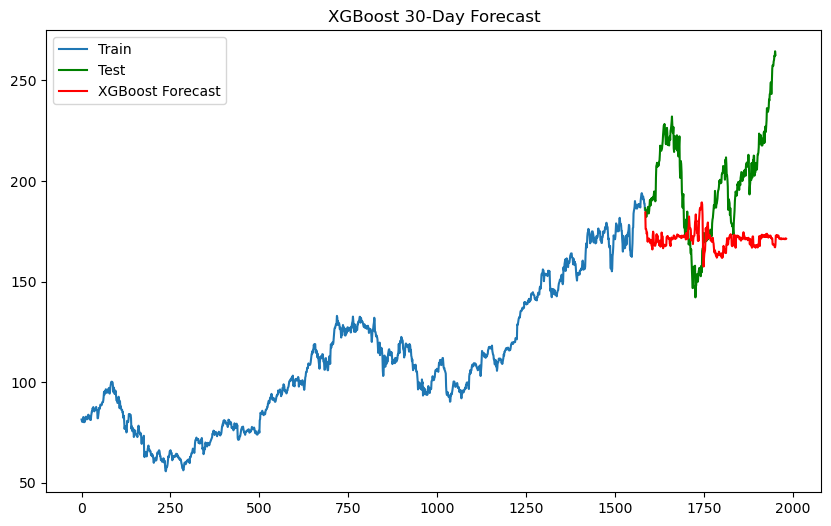

In [126]:
plt.figure(figsize=(10,6))
plt.plot(y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test', color='green')
plt.plot(y_test.index, forecast_xgb, label='XGBoost Forecast', color='red')
plt.title("XGBoost 30-Day Forecast")
plt.legend()
plt.show()

In [127]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [128]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.03, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [129]:
xgb_model = XGBRegressor()

In [130]:
xgb_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [131]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

In [132]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.03, 0.1], 'max_depth': [3, 5], 'n_estimators': [100, 200], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [133]:
print("Best Params:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best Score (Negative MSE): -582.0441151634254


In [134]:
best_xgb = grid_search.best_estimator_

In [135]:
best_pred = best_xgb.predict(x_test)

In [136]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# ensure 1-D arrays
y = np.asarray(y_test).ravel()
yhat = np.asarray(best_pred).ravel()

# mask by positions where y is finite (no NaN)
mask = ~np.isnan(y)
print("valid points:", mask.sum(), "/", len(mask))

y_valid = y[mask]
yhat_valid = yhat[mask]

rmse_best = np.sqrt(mean_squared_error(y_valid, yhat_valid))
mae_best  = mean_absolute_error(y_valid, yhat_valid)
mape_best = mean_absolute_percentage_error(y_valid, yhat_valid)
r2_best = r2_score(y_valid, yhat_valid)
accuracy_best = (1 - mape_best) * 100

print(f"RMSE: {rmse_best:.4f}, MAE: {mae_best:.4f}, MAPE: {mape_best:.4%}, Accuracy: {accuracy_best:.2f}%")


valid points: 367 / 397
RMSE: 39.3794, MAE: 33.6772, MAPE: 16.1055%, Accuracy: 83.89%


In [137]:
print("Optimized XGBoost RMSE:", rmse_best)
print("Optimized XGBoost MAE:", mae_best)
print("Optimized XGBoost MAPE:", mape_best)
print("Optimized XGBoost Accuracy (%):", accuracy_best)

Optimized XGBoost RMSE: 39.379446151115516
Optimized XGBoost MAE: 33.67716983810882
Optimized XGBoost MAPE: 0.1610549803399484
Optimized XGBoost Accuracy (%): 83.89450196600517


### LSTM

In [138]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [139]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
data = df[['Close']].values
dates = df['Date'].values

In [140]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [141]:
scaler_lstm = MinMaxScaler()
train_scaled = scaler_lstm.fit_transform(train_data)
test_scaled = scaler_lstm.transform(test_data)

In [142]:
SEQ_LEN = 60
def create_sequences(dataset):
    X, y = [], []
    for i in range(SEQ_LEN, len(dataset)):
        X.append(dataset[i-SEQ_LEN:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)
X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (1525, 60, 1)
X_test: (337, 60, 1)


In [143]:
model = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0202 - val_loss: 0.0053
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0

In [145]:
pred_scaled = model.predict(X_test)
dummy_test = np.zeros((len(pred_scaled), 1))
dummy_test[:, 0] = pred_scaled[:, 0]
pred_prices = scaler_lstm.inverse_transform(dummy_test)
actual_test = scaler_lstm.inverse_transform(test_scaled[SEQ_LEN:])

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step 


In [146]:
future_preds_scaled = []
last_seq = test_scaled[-SEQ_LEN:]
current_seq = last_seq.reshape(1, SEQ_LEN, 1)
for _ in range(30):
    pred = model.predict(current_seq)[0][0]
    future_preds_scaled.append(pred)
    current_seq = np.append(current_seq[:, 1:, :], [[[pred]]], axis=1)

dummy_future = np.zeros((30, 1))
dummy_future[:, 0] = future_preds_scaled
future_prices = scaler_lstm.inverse_transform(dummy_future)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

In [147]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Flatten arrays
y_true = actual_test.ravel()
y_pred = pred_prices.ravel()

# Safe mask to remove NaNs if any
mask = ~np.isnan(y_true)
y_true = y_true[mask]
y_pred = y_pred[mask]

# Metrics
lstm_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
lstm_mae = mean_absolute_error(y_true, y_pred)
lstm_mape = mean_absolute_percentage_error(y_true, y_pred)
lstm_r2 = r2_score(y_true, y_pred)
accuracy = (1 - mape)

# Print results
print("RMSE:", lstm_rmse)
print("MAE:", lstm_mae)
print("MAPE:", lstm_mape)
print("r2:", lstm_r2)


RMSE: 7.249064960065468
MAE: 5.9938424701870145
MAPE: 0.029753164300051448
r2: 0.9178102077260412


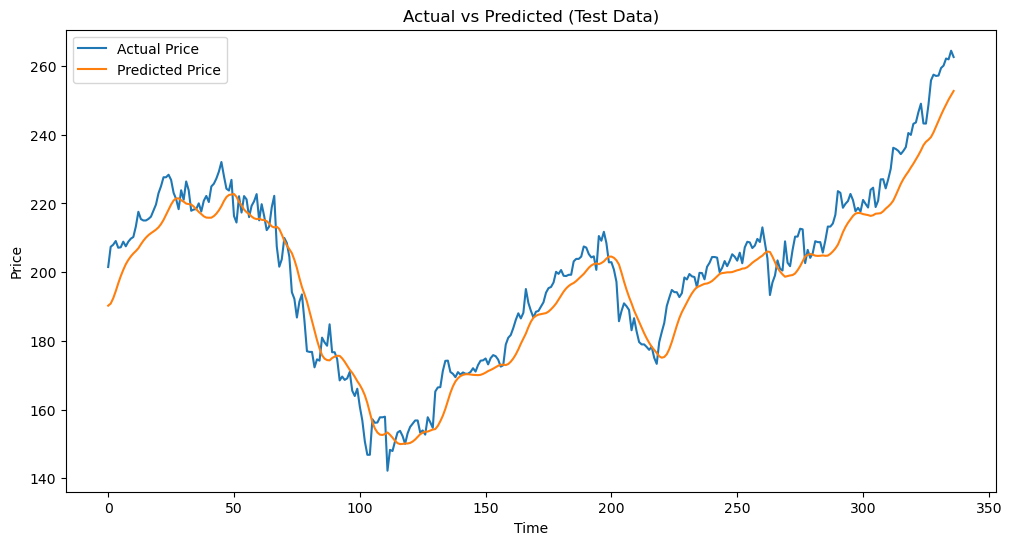

In [148]:
#Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(actual_test, label="Actual Price")
plt.plot(pred_prices, label="Predicted Price")
plt.title("Actual vs Predicted (Test Data)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

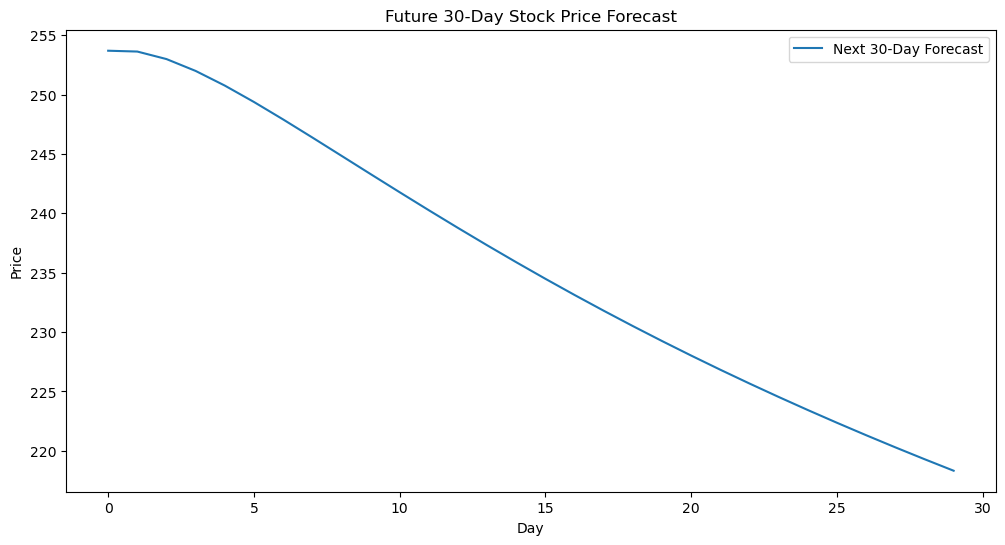

In [149]:
#Next 30 Day Forecast
plt.figure(figsize=(12,6))
plt.plot(future_prices, label="Next 30-Day Forecast")
plt.title("Future 30-Day Stock Price Forecast")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

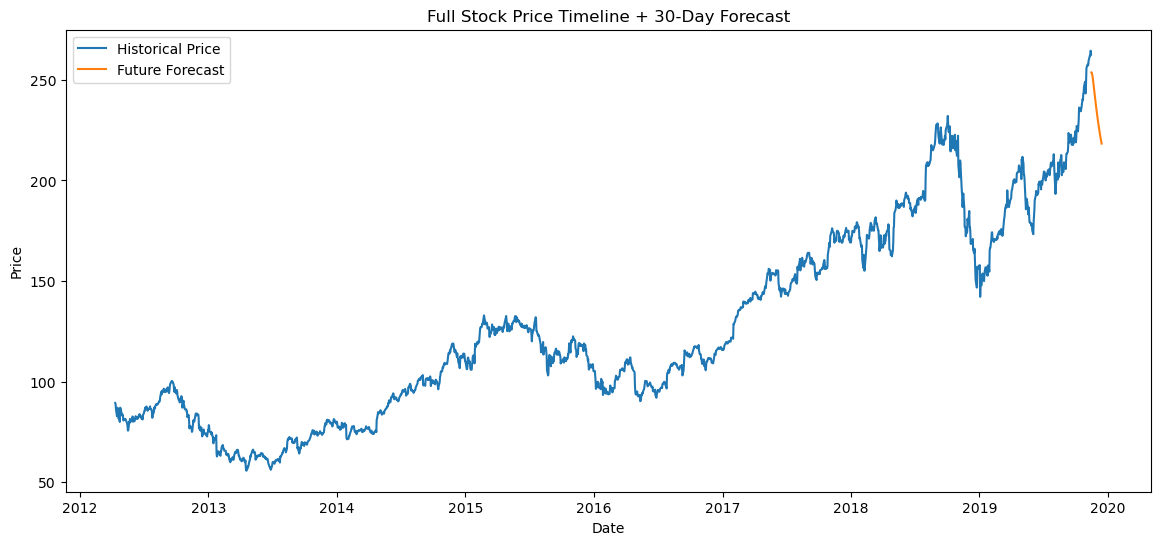

In [150]:
full_data = list(df['Close'])
extended_dates = pd.date_range(df['Date'].iloc[-1], periods=31, inclusive='right')
plt.figure(figsize=(14,6))
plt.plot(df['Date'], full_data, label="Historical Price")
plt.plot(extended_dates, future_prices, label="Future Forecast")
plt.title("Full Stock Price Timeline + 30-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

### ARIMA

In [151]:
series = df.set_index("Date")["Close"]
series = series.dropna()


In [152]:
train_size = int(len(series) * 0.80)
train_raw = series[:train_size]
test_raw = series[train_size:]


In [153]:
scaler_arima = MinMaxScaler()

train_scaled = scaler_arima.fit_transform(train_raw.values.reshape(-1,1))
test_scaled = scaler_arima.transform(test_raw.values.reshape(-1,1))

train = pd.Series(train_scaled.flatten(), index=train_raw.index)
test = pd.Series(test_scaled.flatten(), index=test_raw.index)


In [154]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
# To avoid warnings
import warnings
warnings.filterwarnings("ignore")

p_values = [0,1,2,3]
d_values = [0,1]
q_values = [0,1,2]

tscv = TimeSeriesSplit(n_splits=4)

best_score = float("inf")
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            cv_errors = []
            for train_idx, val_idx in tscv.split(train):
                train_cv = train.iloc[train_idx]
                val_cv = train.iloc[val_idx]

                try:
                    model = ARIMA(train_cv, order=(p,d,q))
                    model_fit = model.fit()
                    preds = model_fit.forecast(steps=len(val_cv))
                    rmse = np.sqrt(mean_squared_error(val_cv, preds))
                    cv_errors.append(rmse)
                except:
                    cv_errors.append(np.inf)

            avg_rmse = np.mean(cv_errors)
            print(f"ARIMA({p},{d},{q}) → CV RMSE: {avg_rmse}")

            if avg_rmse < best_score:
                best_score = avg_rmse
                best_order = (p,d,q)

print("\nBest ARIMA Order:", best_order, "CV RMSE:", best_score)


ARIMA(0,0,0) → CV RMSE: 0.26101931591686744
ARIMA(0,0,1) → CV RMSE: 0.2606461113804587
ARIMA(0,0,2) → CV RMSE: 0.260372918318779
ARIMA(0,1,0) → CV RMSE: 0.16220140136000136
ARIMA(0,1,1) → CV RMSE: 0.16217222144009322
ARIMA(0,1,2) → CV RMSE: 0.16219181804659763
ARIMA(1,0,0) → CV RMSE: 0.17376776252403026
ARIMA(1,0,1) → CV RMSE: 0.17610273800579335
ARIMA(1,0,2) → CV RMSE: 0.17663256191416737
ARIMA(1,1,0) → CV RMSE: 0.162184561254374
ARIMA(1,1,1) → CV RMSE: 0.16242340233625216
ARIMA(1,1,2) → CV RMSE: 0.16212736442504416
ARIMA(2,0,0) → CV RMSE: 0.17074675806395706
ARIMA(2,0,1) → CV RMSE: 0.17656621614950888
ARIMA(2,0,2) → CV RMSE: 0.1761372566000171
ARIMA(2,1,0) → CV RMSE: 0.1621722135016289
ARIMA(2,1,1) → CV RMSE: 0.1624471203699703
ARIMA(2,1,2) → CV RMSE: 0.16219527148495808
ARIMA(3,0,0) → CV RMSE: 0.17661394894729238
ARIMA(3,0,1) → CV RMSE: 0.17871883437476016
ARIMA(3,0,2) → CV RMSE: 0.18057570511241858
ARIMA(3,1,0) → CV RMSE: 0.16218183373331768
ARIMA(3,1,1) → CV RMSE: 0.16217575157636

In [155]:
final_model = ARIMA(train, order=best_order)
final_fit = final_model.fit()

forecast_scaled = final_fit.forecast(steps=len(test))

In [156]:
forecast = scaler_arima.inverse_transform(forecast_scaled.values.reshape(-1,1)).flatten()
actual = scaler_arima.inverse_transform(test.values.reshape(-1,1)).flatten()


In [157]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

arima_rmse = np.sqrt(mean_squared_error(actual, forecast))
arima_mae = mean_absolute_error(actual, forecast)
arima_mape = (np.abs((actual - forecast) / actual).mean()) * 100
arima_r2 = r2_score(actual, forecast)

print("RMSE :", arima_rmse)
print("MAE  :", arima_mae)
print("MAPE  :",arima_mape)
print("R²   :", arima_r2)


RMSE : 26.589547908822226
MAE  : 21.002686934899515
MAPE  : 10.256361549026103
R²   : -0.2634769044033618


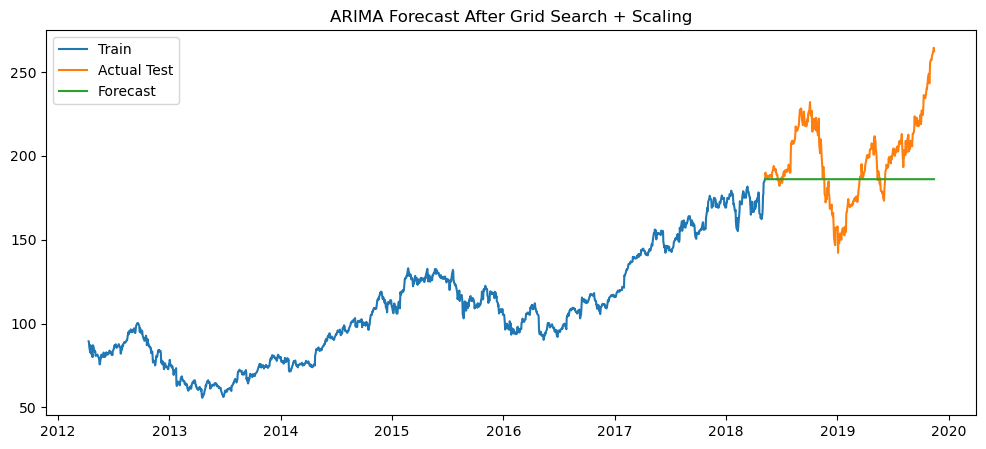

In [158]:
plt.figure(figsize=(12,5))
plt.plot(train_raw.index, train_raw, label="Train")
plt.plot(test_raw.index, actual, label="Actual Test")
plt.plot(test_raw.index, forecast, label="Forecast")
plt.legend()
plt.title("ARIMA Forecast After Grid Search + Scaling")
plt.show()


In [159]:
import pandas as pd

results = {
    "Model": ["ARIMA", "LSTM", "XGBoost", "SARIMA"],
    "RMSE": [arima_rmse, lstm_rmse, rmse_best, rmse],
    "MAE": [arima_mae, lstm_mae, mae_best, mae],
    "MAPE": [arima_mape, lstm_mape, mape_best, mape],  
    "R2": [arima_r2, lstm_r2, accuracy,r2]
}

df = pd.DataFrame(results)
print(df)


     Model       RMSE        MAE       MAPE        R2
0    ARIMA  26.589548  21.002687  10.256362 -0.263477
1     LSTM   7.249065   5.993842   0.029753  0.917810
2  XGBoost  39.379446  33.677170   0.161055  0.507403
3   SARIMA   0.208297   0.963757   0.492597  0.997189


In [160]:
import pickle

with open("sarimax_model.pkl", "wb") as f:
    pickle.dump(res, f)

with open("feature_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model & Scaler saved successfully!")

Model & Scaler saved successfully!
